In [36]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from glob2 import glob
import  os.path
from scipy.spatial import distance
from platform import platform

nColorHistogramCategories=64
nMatchingImagesToShow = 5
#dataPath = os.path.realpath('') + '/testing_images/'
dataPath = os.path.realpath('') + '/data/'

In [5]:
im1 = cv2.imread('/Users/Anita/Documents/HMDA/2ndSemester/IREI/CBIR/python_project/testingImg/im1.jpg')
im2 = cv2.imread('/Users/Anita/Documents/HMDA/2ndSemester/IREI/CBIR/python_project/testingImg/im2.jpg')
im3 = cv2.imread('/Users/Anita/Documents/HMDA/2ndSemester/IREI/CBIR/python_project/testingImg/im3.jpg')


# Feature extraction functions

In [6]:
def ColorHistogram(img):
    # Calculte and normalize the histogram for each channel then append them
    histogram = cv2.calcHist([img],[0],None,[nColorHistogramCategories],[0,256])
    histogram = cv2.normalize(histogram, None)

    ch1_histogram = cv2.calcHist([img],[1],None,[nColorHistogramCategories],[0,256])
    ch1_histogram = cv2.normalize(ch1_histogram, None)
    histogram = np.vstack((histogram, ch1_histogram))

    ch2_histogram = cv2.calcHist([img],[2],None,[nColorHistogramCategories],[0,256])
    ch2_histogram = cv2.normalize(ch2_histogram, None)
    histogram = np.vstack((histogram, ch2_histogram))

    return histogram

def TextureGaborFilter(img):
    # returns the img filtered by the filter list of kernels in several orientations
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 30):
        params = {'ksize':(ksize, ksize), 'sigma':1.0, 'theta':theta, 'lambd':15.0,
                  'gamma':0.02, 'psi':0, 'ktype':cv2.CV_32F}
        kern = cv2.getGaborKernel(**params)
        kern /= 1.5*kern.sum()
        filters.append((kern,params))

    accum = np.zeros_like(img)
    for kern,params in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    accum = accum.reshape(-1, 1)
    return accum

def FusionFeaturesVector(img):
    # Create the features of each category
    features_vector = ColorHistogram(img)

    gabor_filtered = TextureGaborFilter(img)
    features_vector = np.vstack((features_vector, gabor_filtered))

    return features_vector

# Index images and store

In [102]:
data = glob(dataPath)
imgFiles = []
imgFiles.extend(glob(dataPath + '*.JPG'))
imgFiles.extend(glob(dataPath + '*.JPEG'))
imgFiles.extend(glob(dataPath + '*.BMP'))
imgFiles.extend(glob(dataPath + '*.PNG'))

# windows is case insensitive so we don't need to add this
if not platform().startswith('Windows'):
    imgFiles.extend(glob(dataPath + '*.jpg'))
    imgFiles.extend(glob(dataPath + '*.jpeg'))
    imgFiles.extend(glob(dataPath + '*.bmp'))
    imgFiles.extend(glob(dataPath + '*.png'))

In [112]:
# create the feature vector for every image
for i, imgFile in enumerate(imgFiles):
    # read image file
    img = cv2.imread(imgFile, 1)
    # convert all images to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save the features vector to files
    histFeaturesVector = ColorHistogram(img)
    texFeaturesVector = TextureGaborFilter(img)
    fusionFeaturesVector = FusionFeaturesVector(img)

    if(imgFile[len(imgFile)-6:] == '.JPEG' or imgFile[len(imgFile)-6:] == '.jpeg' ):
        histFeaturesVectorFileName = dataPath + 'histogramIdx/' + imgFile[70:len(imgFile)-5]
        texFeaturesVectorFileName = dataPath + 'textureIdx/' + imgFile[70:len(imgFile)-5]
        fusionFeaturesVectorFileName = dataPath + 'fusionIdx/' + imgFile[70:len(imgFile)-5]

    else:
        histFeaturesVectorFileName = dataPath + 'histogramIdx/' + imgFile[70:len(imgFile)-4]
        texFeaturesVectorFileName = dataPath + 'textureIdx/' + imgFile[70:len(imgFile)-4]
        fusionFeaturesVectorFileName = dataPath + 'fusionIdx/' + imgFile[70:len(imgFile)-4]

    np.save(histFeaturesVectorFileName, histFeaturesVector)
    np.save(texFeaturesVectorFileName, texFeaturesVector)
    np.save(fusionFeaturesVectorFileName, fusionFeaturesVector)

# Collect feature files

In [113]:
# now only get feature files in each folder (category)
histFolder = dataPath + 'histogramIdx/'
texFolder = dataPath + 'textureIdx/'
fusionFolder = dataPath + 'fusionIdx/'
histFeatureFiles = []
texFeatureFiles = []
fusionFeatureFiles = []

# save the paths in np array
histFeatureFiles.extend(glob(str(histFolder) + '*.npy'))
texFeatureFiles.extend(glob(str(texFolder) + '*.npy'))
fusionFeatureFiles.extend(glob(str(fusionFolder) + '*.npy'))

In [114]:
histFeatureVector = [] # hist
texFeatureVector = [] # tex
fusionFeatureVector = [] # fusion
def CollectHistFeatures():
    for i, featureFile in enumerate(histFeatureFiles):
        # get image path to be able to show it later
        imgName = featureFile[83:].replace('.npy', '')
        # load the numpy array and add it to the list of feature vectors
        histFeatureVector.append([imgName, np.load(featureFile)])

def CollectTexFeatures():
    for i, featureFile in enumerate(texFeatureFiles):
        # get image path to be able to show it later
        imgName = featureFile[81:].replace('.npy', '')
        # load the numpy array and add it to the list of feature vectors
        texFeatureVector.append([imgName, np.load(featureFile)])

def CollectFusionFeatures():
    for i, featureFile in enumerate(fusionFeatureFiles):
        # get image path to be able to show it later
        imgName = featureFile[80:].replace('.npy', '')
        # load the numpy array and add it to the list of feature vectors
        fusionFeatureVector.append([imgName, np.load(featureFile)])

In [115]:
CollectHistFeatures()
CollectTexFeatures()
CollectFusionFeatures()

# Query image

In [130]:
# load and extract features
def QueryImg(imgName, searchVector):
    queryImg = cv2.imread(os.path.realpath('') + '/queryImg/' + str(imgName))
    queryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2RGB)

    histQuery = ColorHistogram(queryImg)
    texQuery = TextureGaborFilter(queryImg)
    fusionQuery = FusionFeaturesVector(queryImg)

    histFeatureVector.sort(key=lambda featureVector: distance.euclidean(featureVector[1], histQuery))
    texFeatureVector.sort(key=lambda featureVector: distance.euclidean(featureVector[1], texQuery))
    fusionFeatureVector.sort(key=lambda featureVector: distance.euclidean(featureVector[1], fusionQuery))

    ShowQueryResults(queryImg, searchVector)

def GetImgPath(element):
   return str(dataPath + element[0]+'.jpg')


def ShowQueryResults(queryImg, searchVector):
    nCols = 3
    nRows = 3
    # Display all results, alongside original image
    results_figure=plt.figure(figsize=(10,10))

    results_figure.add_subplot(nRows, nCols, 1)
    plt.suptitle('Query results', fontsize=20)
    plt.axis('off')
    plt.title('Query image', fontsize=14)
    plt.imshow(queryImg)

    if nMatchingImagesToShow > nRows * nCols:
        nMatching_images_to_show = nRows * nCols


    for i in range(0, nMatchingImagesToShow):
        results_figure.add_subplot(nRows, nCols, i+2)
        plt.axis('off')
        plt.title('Match number ' + str(i+1), fontsize=14)
        # read image file
        match = cv2.imread(GetImgPath(searchVector[i]), 1)
        # convert all images to RGB
        match = cv2.cvtColor(match, cv2.COLOR_BGR2RGB)
        plt.imshow(match)
    plt.show()

# Results

## Watch
### Histogram

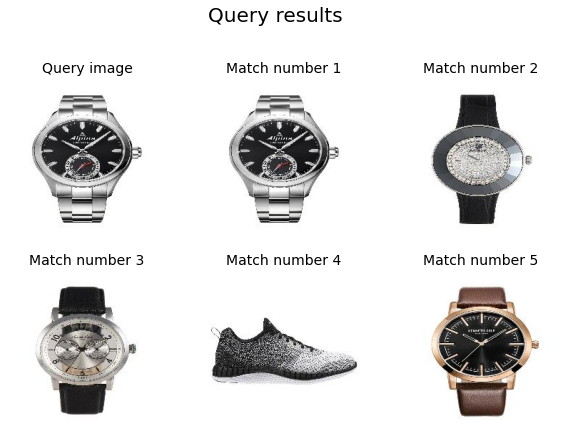

In [131]:
QueryImg('105565801.jpg', histFeatureVector)

### Texture

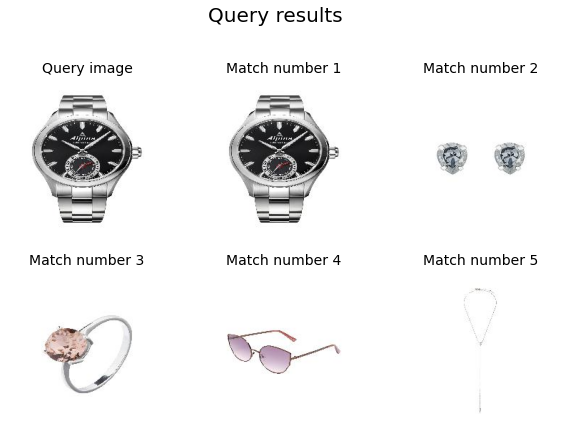

In [123]:
QueryImg('105565801.jpg', texFeatureVector)

### Fusion

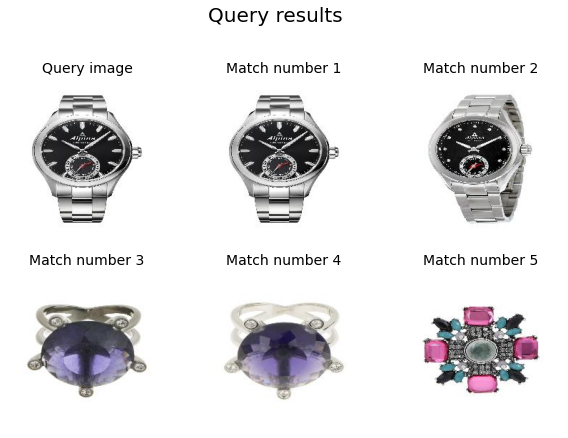

In [124]:
QueryImg('105565801.jpg', fusionFeatureVector)

## Sunglasses
### Histogram

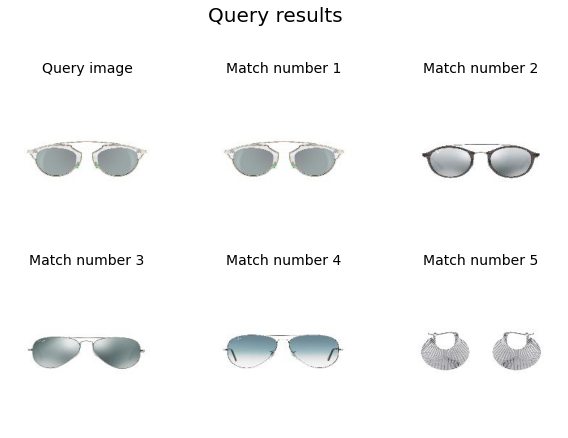

In [132]:
QueryImg('105391640.jpg', histFeatureVector)

### Texture

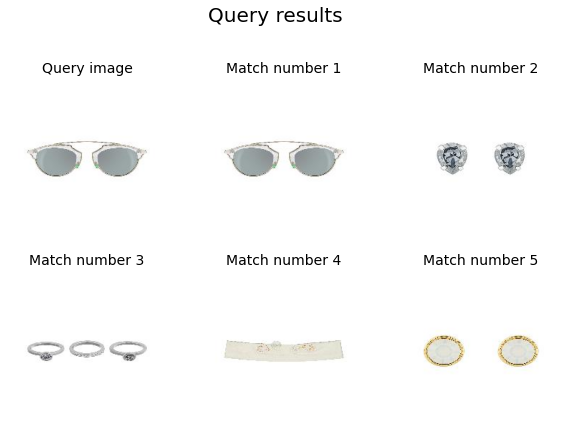

In [133]:
QueryImg('105391640.jpg', texFeatureVector)

### Fusion

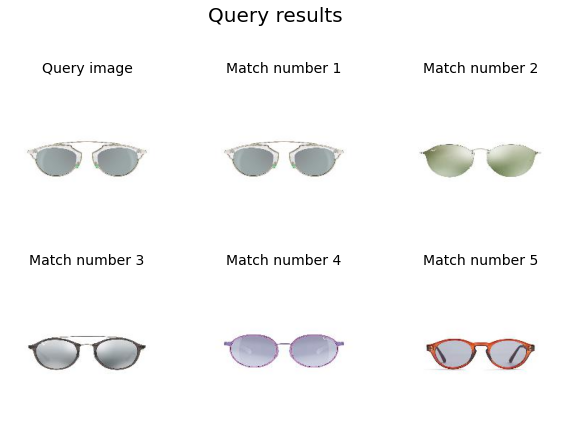

In [134]:
QueryImg('105391640.jpg', fusionFeatureVector)


## Jeans 1
### Histogram

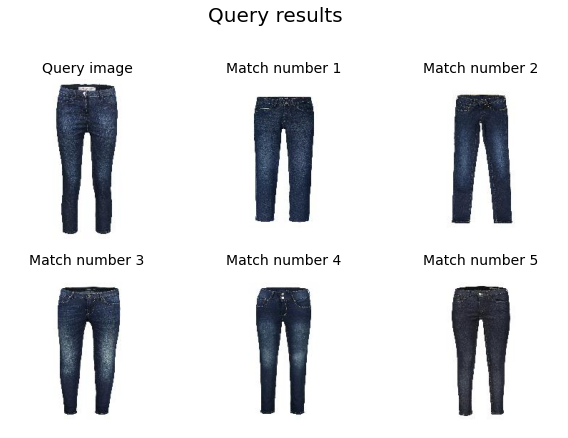

In [160]:
QueryImg('117009937.jpg', histFeatureVector)

### Texture

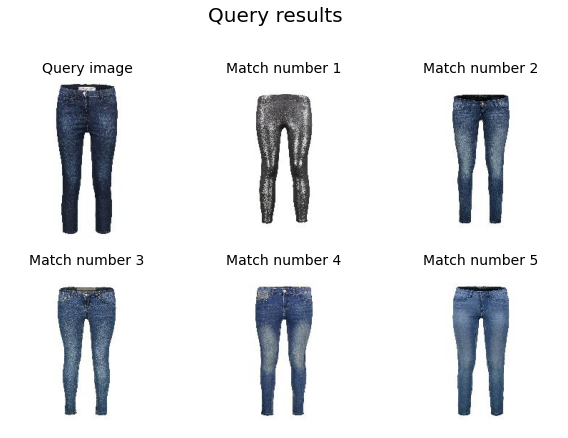

In [161]:
QueryImg('117009937.jpg', texFeatureVector)

### Fusion

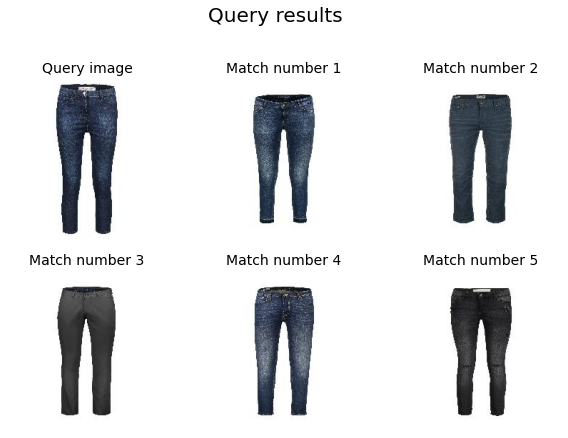

In [162]:
QueryImg('117009937.jpg', fusionFeatureVector)


## Jeans 2
### Histogram

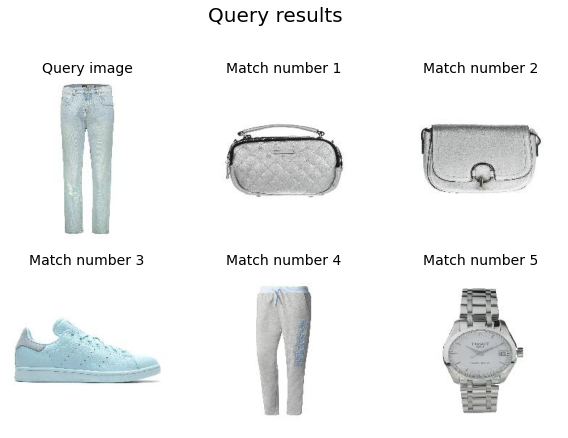

In [163]:
QueryImg('117005254.jpg', histFeatureVector)

### Texture

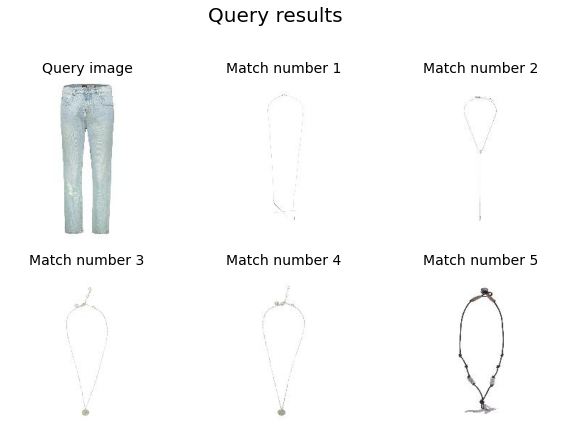

In [164]:
QueryImg('117005254.jpg', texFeatureVector)

### Fusion

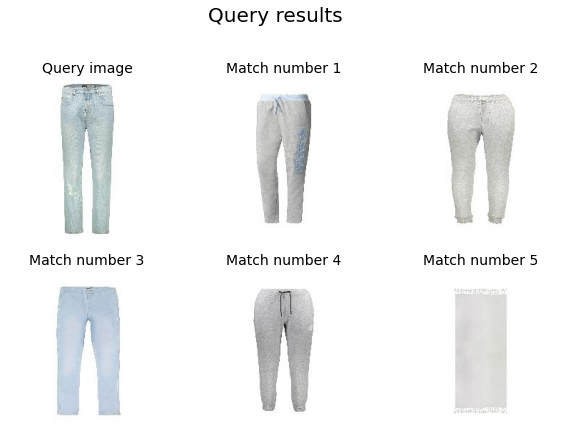

In [165]:
QueryImg('117005254.jpg', fusionFeatureVector)


## Jumper
### Histogram

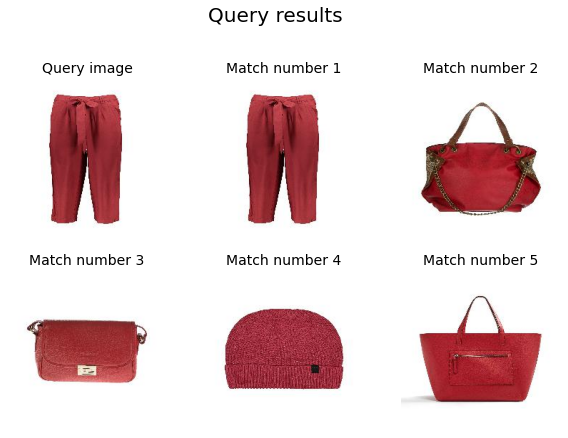

In [175]:
QueryImg('105494727.jpg', histFeatureVector)

### Texture

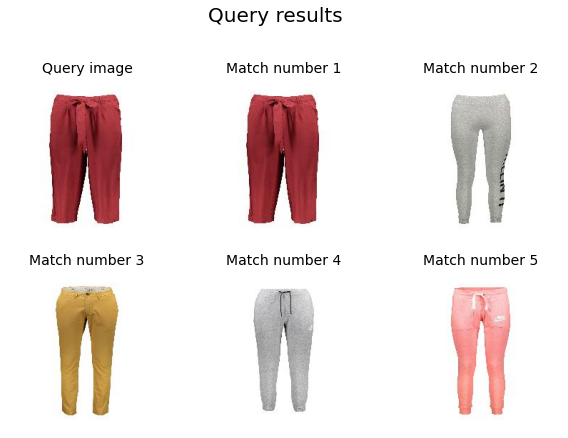

In [176]:
QueryImg('105494727.jpg', texFeatureVector)

### Fusion

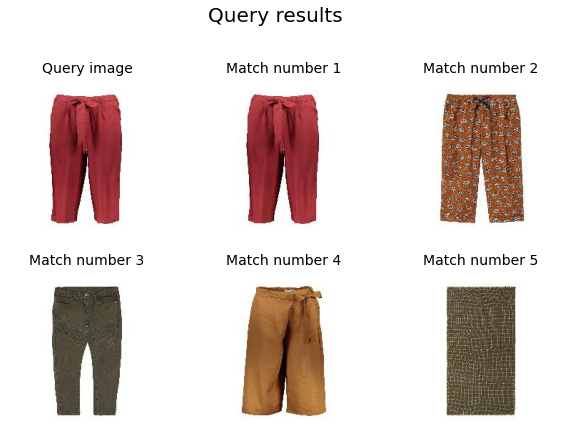

In [178]:
QueryImg('105494727.jpg', fusionFeatureVector)